### 手順
1. すべてのStateをpythonで読み込む。
2. もう一度Fermiクラス, Stateクラスを再現する。(各State間が遷移可能かどうかを確認する必要があるため)
<br><br>

### 必要なもの
* 遷移可能かどうか
  * どうやって管理する?→Fermiインスタンスが隣接行列を持つようにする
* 

In [1]:
import pandas as pd
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class State(object):
    n = 0

    def __init__(self, v: list[int], score: int):
        self.v = v
        self.score = score
        State.n = len(v)

    def __repr__(self) -> str:
        return str(self.score) + "ε: " + str(self.v)


class Fermi(object):
    def __init__(self, states: list[State], stable: bool = True, kTe: float = 1, ne: float = 1e+19):
        self.states = states
        self.n = State.n
        self.ne = ne
        self.kTe = kTe
        self.num_states = len(states)
        self.stable = stable
        self.adj_matrix = np.zeros((self.num_states, self.num_states))
        self.excitation_matrix = np.zeros_like(self.adj_matrix)
        self.deexcitation_matrix = np.zeros_like(self.adj_matrix)
        self.emission_matrix = np.zeros_like(self.adj_matrix)

    # fermi.cppのis_connected()は片方向の遷移が可能かどうかを見てるが、下記のは両方向の遷移が可能かも見れる
    @staticmethod
    def is_connected(s1: State, s2: State) -> bool:
        if len(set([*s1.v, *s2.v])) == s1.n + 1:
            return True
        return False

    # 隣接行列を求める(使わない)
    def make_adj_matrix(self, symm: bool=False) -> None:
        for i in range(self.num_states):
            for j in range(i+1, self.num_states):
                if Fermi.is_connected(self.states[i], self.states[j]):
                    self.adj_matrix[i, j] = 1
        if symm:
            self.adj_matrix += self.adj_matrix.T

    # 上三角行列
    def _make_matrices(self) -> None:
        for i in range(self.num_states):
            for j in range(i+1, self.num_states):
                if Fermi.is_connected(self.states[i], self.states[j]):
                    # i→jの遷移
                    self.excitation_matrix[i, j] = self.ne * np.exp(-(self.states[j].score - self.states[i].score)/self.kTe)
                    # j→iの遷移
                    self.deexcitation_matrix[i, j] = self.ne
                    if not self.stable:
                        # j→iの遷移
                        self.emission_matrix[i, j] = (self.states[j].score - self.states[i].score)**3


    def _solve_equation(self) -> NDArray[float]:
        if np.all(self.excitation_matrix == 0):
            self._make_matrices()
        C_ = np.diag(self.excitation_matrix.sum(axis=1))
        F_ = np.diag(self.deexcitation_matrix.sum(axis=0))
        C = self.excitation_matrix
        F = self.deexcitation_matrix
        coeff_matrix = C_ - F - C.T + F_
        if not self.stable:
            A_ = np.diag(self.emission_matrix.sum(axis=0))
            A = self.emission_matrix
            coeff_matrix += A_ - A
        self.coeff_matrix = coeff_matrix.copy()
        
        # 対角成分の最大値で正規化し、正負を反転させることで、対角行列のみ負の行列を作成。さらにそこに単位行列を足すことで正行列を作成。
        # ペロン=フロベニウスの定理を用いて、最大の固有値1に対応する固有ベクトルはすべて正の成分を持つことになる。
        normalized_matrix = - coeff_matrix / np.max(np.abs(np.diag(coeff_matrix))) + np.eye(C.shape[0])
        if np.all(normalized_matrix > 0):
            print("normalized_matrix is positive")
        elif np.all(normalized_matrix >= 0):
            print("normalized_matrix does't include nagative value. (includes 0 value)")
        else:
            print("normalized_matrix includes negative value")
        # eigens, eigenvectors = np.linalg.eig(normalized_matrix)
        # x = -(eigenvectors[:, np.argmax(eigens)])
        # return x / np.sum(x)
        x = Fermi.power_method(normalized_matrix)
        return x / np.sum(x)

    # べき乗法
    @staticmethod
    def power_method(matrix: NDArray[NDArray[float]]) -> NDArray[float]:
        # 初期化
        x = np.zeros(matrix.shape[0])
        x[0] = 1
        while True:
            y = np.dot(matrix, x)
            eigen = np.dot(y, x)
            if np.abs(1 - eigen) < 1e-10:
                return y
            x = y / np.linalg.norm(y)
        
    
    # score[ε]: 割合 の形の辞書型がほしい
    def get_population(self) -> tuple[NDArray[int], NDArray[float]]:
        x = self._solve_equation()
        dct = {}
        for i, state in enumerate(self.states):
            if dct.get(state.score):
                dct[state.score] += x[i]
            else:
                dct[state.score] = x[i]
        scores = np.fromiter(dct.keys(), dtype=int)
        population = np.fromiter(dct.values(), dtype=float)
        return scores, population


def csv_to_states(path: str = './output/states3.csv') -> list[State]:
    data = pd.read_csv(path, header=0).values
    scores = data[:, 0]
    array = data[:, 1:]
    size = array.shape[0]
    return [State(array[i], scores[i]) for i in range(size)]


def plot(scores, population, stable, kTe, ne, type="plot"):
    if type == "plot":
        plt.plot(scores, population)
    elif type == "scatter":
        plt.scatter(scores, population)
    else:
        plt.plot(scores, population)
    plt.title(f"stable = {stable},   k * T_e = {kTe},   ne = {ne}")
    plt.yscale("log")
    plt.ylim(1e-20, 5)
    plt.xlabel("total energy [ε]")
    plt.ylabel("population [%] (log scale)")
    plt.show()

# states = csv_to_states()



## 電子数3, lim_size20

normalized_matrix does't include nagative value. (includes 0 value)
normalized_matrix does't include nagative value. (includes 0 value)


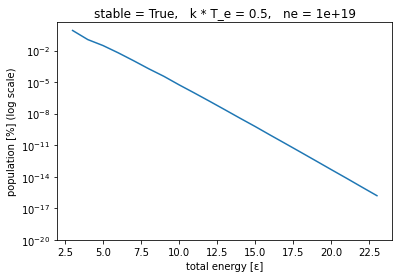

In [16]:
states3 = csv_to_states()

# 放射脱励起の影響を無視している(定常状態)
stable = True
kTe = 0.5
ne = 1e+19
fermi3 = Fermi(states3, stable=stable, kTe=kTe, ne=ne)
scores, population = fermi3.get_population()
x = fermi3._solve_equation()
plot(scores, population, stable, kTe, ne)

normalized_matrix does't include nagative value. (includes 0 value)
normalized_matrix does't include nagative value. (includes 0 value)


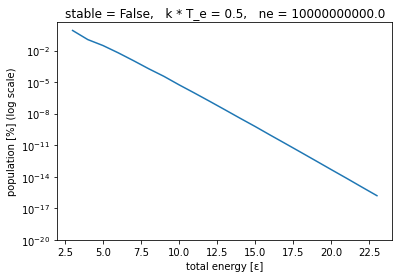

In [17]:
# 放射脱励起の影響も考慮しているものの、neがまだまだ大きいので、放射脱励起を無視したときと変わらない

stable = False
kTe = 0.5
ne = 1e+10
fermi3 = Fermi(states3, stable=stable, kTe=kTe, ne=ne)
scores, population = fermi3.get_population()
x = fermi3._solve_equation()
plot(scores, population, stable, kTe, ne)

normalized_matrix does't include nagative value. (includes 0 value)
normalized_matrix does't include nagative value. (includes 0 value)


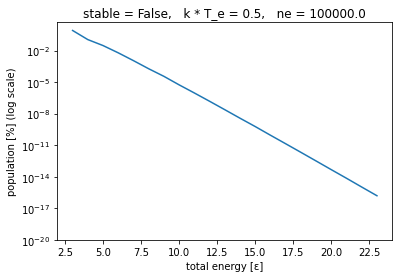

In [18]:
stable = False
kTe = 0.5
ne = 1e+5
fermi3 = Fermi(states3, stable=stable, kTe=kTe, ne=ne)
scores, population = fermi3.get_population()
x = fermi3._solve_equation()
plot(scores, population, stable, kTe, ne)

* kTeが大きい == exp(...)が1に近づき、ほとんどneのみで決定されるようになるため、衝突励起が大きくなる
* kTeが小さい == exp(...)が1よりもかなり小さくなり、neを1以上の値で割ることに等しくなり、衝突励起が小さくなる

* neが大きい == 衝突励起・脱励起が放射脱励起よりも優勢となる(定常状態)
* neが小さい == 放射脱励起の効果が無視できなくなってくる

normalized_matrix does't include nagative value. (includes 0 value)


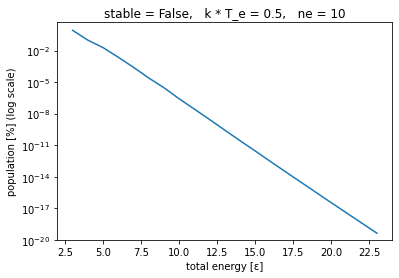

In [19]:
# neの値をかなり小さくして、放射脱励起の影響が現れてきた

stable = False
kTe = 0.5
ne = 10
fermi3 = Fermi(states3, stable=stable, kTe=kTe, ne=ne)
scores, population = fermi3.get_population()
plt.plot(scores, population)
plt.title(f"stable = {stable},   k * T_e = {kTe},   ne = {ne}")
plt.yscale("log")
plt.ylim(1e-20, 5)
plt.xlabel("total energy [ε]")
plt.ylabel("population [%] (log scale)")
plt.show()

normalized_matrix does't include nagative value. (includes 0 value)


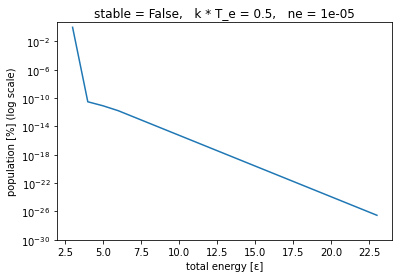

In [25]:
# neの値をかなり小さくして、放射脱励起の影響が現れてきた

stable = False
kTe = 0.5
ne = 0.00001
fermi3 = Fermi(states3, stable=stable, kTe=kTe, ne=ne)
scores, population = fermi3.get_population()
plt.plot(scores, population)
plt.title(f"stable = {stable},   k * T_e = {kTe},   ne = {ne}")
plt.yscale("log")
plt.ylim(1e-30, 5)
plt.xlabel("total energy [ε]")
plt.ylabel("population [%] (log scale)")
plt.show()

(357.0, 0.0)

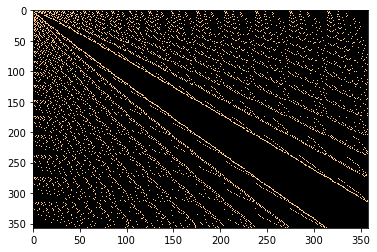

In [ ]:
fermi3 = Fermi(states3)
fermi3.make_adj_matrix(symm=True)
adj_mat = fermi3.adj_matrix
plt.pcolormesh(adj_mat, cmap="copper")
plt.ylim(adj_mat.shape[0]-1, 0)

### Mixしてプロット

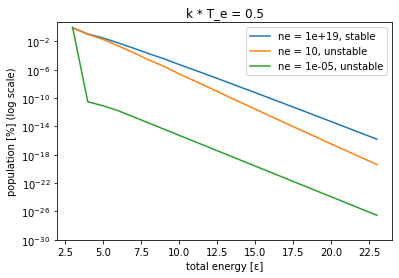

In [29]:
fermi_stable = Fermi(states3, stable=True, kTe=0.5, ne=1e+19)
fermi_ne_10 = Fermi(states3, stable=False, kTe=0.5, ne=10)
fermi_ne_1e05 = Fermi(states3, stable=False, kTe=0.5, ne=1e-05)

scores, population_stable = fermi_stable.get_population()
_, population_ne_10 = fermi_ne_10.get_population()
_, population_ne_1e05 = fermi_ne_1e05.get_population()


plt.plot(scores, population_stable, label="ne = 1e+19, stable")
plt.plot(scores, population_ne_10, label="ne = 10, unstable")
plt.plot(scores, population_ne_1e05, label="ne = 1e-05, unstable")
plt.legend()
plt.title(f"k * T_e = {kTe}")
plt.yscale("log")
plt.ylim(1e-30, 5)
plt.xlabel("total energy [ε]")
plt.ylabel("population [%] (log scale)")
plt.show()

## 電子数2, lim_size 1

In [9]:
states2 = csv_to_states(path = './output/states2.csv')

# lim_size(上り幅)が1の時(二準位系)
def analytical_solution(stable: bool, kTe: float, ne: float) -> NDArray[float]:
    a = ne * np.exp(-1/kTe)
    b = ne if stable else ne+1
    return np.array([b/(a+b), a/(a+b)])

normalized_matrix does't include nagative value. (includes 0 value)


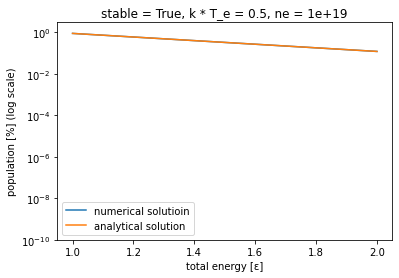

In [18]:
# 放射脱励起の影響を無視している(定常状態)
stable = True
kTe = 0.5
ne = 1e+19
fermi2 = Fermi(states2, stable=stable, kTe=kTe, ne=ne)
scores, population = fermi2.get_population()

# 解析解
analytical_population = analytical_solution(stable=stable, kTe=kTe, ne=ne)

plt.title(f"stable = {stable}, k * T_e = {kTe}, ne = {ne}")
plt.plot(scores, population, label="numerical solutioin")
plt.plot(scores, analytical_population, label="analytical solution")
plt.legend()
plt.yscale("log")
plt.ylim(1e-10, 3)
plt.xlabel("total energy [ε]")
plt.ylabel("population [%] (log scale)")
plt.show()

normalized_matrix does't include nagative value. (includes 0 value)


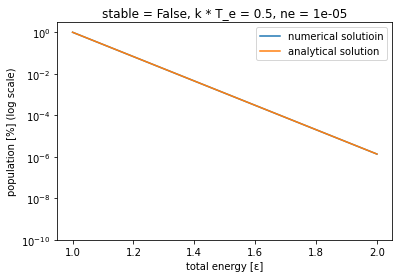

In [19]:
# neの値をかなり小さくして、放射脱励起の影響が現れてきた

stable = False
kTe = 0.5
ne = 0.00001

fermi2 = Fermi(states2, stable=stable, kTe=kTe, ne=ne)
scores, population = fermi2.get_population()

# 解析解
analytical_population = analytical_solution(stable=stable, kTe=kTe, ne=ne)

plt.title(f"stable = {stable}, k * T_e = {kTe}, ne = {ne}")
plt.plot(scores, population, label="numerical solutioin")
plt.plot(scores, analytical_population, label="analytical solution")
plt.legend()
plt.yscale("log")
plt.ylim(1e-10, 3)
plt.xlabel("total energy [ε]")
plt.ylabel("population [%] (log scale)")
plt.show()

In [17]:
for i in range(fermi2.num_states):
    for j in range(i+1, fermi2.num_states):
        if Fermi.is_connected(fermi2.states[i], fermi2.states[j]):
            # i→jの遷移
            fermi2.excitation_matrix[i, j] = fermi2.ne * np.exp(-(fermi2.states[j].score - fermi2.states[i].score)/fermi2.kTe)
            # j→iの遷移
            fermi2.emission_matrix[i, j] = (fermi2.states[j].score - fermi2.states[i].score)**3

In [23]:
population

array([9.99998647e-01, 1.35333747e-06])

In [25]:
analytical_solution(ne, kTe)

array([9.99998647e-01, 1.35333747e-06])